# Easy Feature Analysis

今回のお題は、生徒のエッセイを書かせてその動作（キー入力、クリック動作等の全ての動作）をキーロガーで記録し、その動作情報をもとにエッセイの採点閣下を予測するもの。


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/'My Drive'/'kaggle'/'LinkingWritingProcess'

/content/drive/My Drive/kaggle/LinkingWritingProcess


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.0 MB/s eta 0:00:00


## (1) Baseline

In [ ]:
import os
import pandas as pd
import numpy as np
import gc
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
pd.set_option("display.max_columns", None)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


訓練データを見てみる。各エッセイ(id)ごとにひとつひとつの詳細な動作が記録されているので、この一つのエッセイを書くのに、それだけの動作がかかったということになる。

In [ ]:
train = pd.read_csv('./data/train_logs.csv')
df_scores = pd.read_csv('./data/train_scores.csv')
df_test = pd.read_csv('./data/test_logs.csv')

train.head(10)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
5,001519c8,6,107296,107400,104,Input,q,q,q,3,1
6,001519c8,7,107469,107596,127,Input,q,q,q,4,1
7,001519c8,8,107659,107766,107,Input,q,q,q,5,1
8,001519c8,9,107743,107852,109,Input,q,q,q,6,1
9,001519c8,10,107840,107978,138,Input,Space,Space,,7,1


In [ ]:
# ID=001519c8を確認する。
## 2556行が1つのエッセイを作成するのにかかっていることが分かる。
train[train['id']=='001519c8']

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2552,001519c8,2553,1781786,1781841,55,Remove/Cut,Backspace,Backspace,q,555,255
2553,001519c8,2554,1781917,1781991,74,Remove/Cut,Backspace,Backspace,q,554,255
2554,001519c8,2555,1782062,1782141,79,Remove/Cut,Backspace,Backspace,q,553,255
2555,001519c8,2556,1782922,1782985,63,Input,q,q,q,554,255


scoresのデータを確認する。このscoreが予測対象となるが、最高で6.0点、最低で0.5点のようだ。

In [ ]:
display(df_scores)
print('Max : ', df_scores['score'].max(), "     Min : ", df_scores['score'].min())

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


Max :  6.0      Min :  0.5


down_time, up_timeはキーを押す動作をイメージすると分かりやすそうだが、down_timeがキーを押し始めた時間、up_keyがキーを離した時間になる。時間はミリ秒(1/1000秒)なので、ほとんどが30分近辺に集中している。

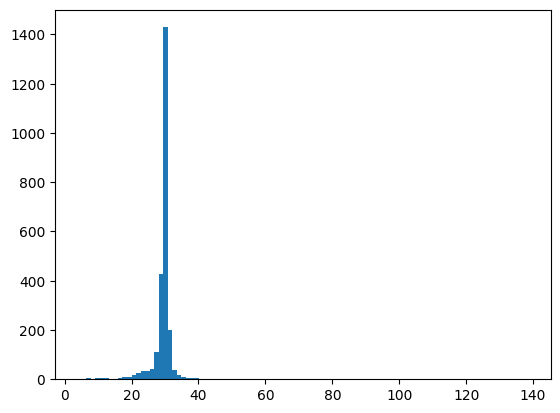

In [ ]:
temp = train[['id','up_time']].groupby('id').max()
temp['up_time'] = temp['up_time']/1000/60
plt.hist(temp['up_time'], bins=100)
plt.show()

次にモデルの構築を行う。  
このコンペは各動作をもとにエッセイの点数を予測するというものなので、まずは素直に動作関係のFeatureを使って予測してみる。

In [ ]:
print(train['activity'].unique())

['Nonproduction' 'Input' 'Remove/Cut' 'Replace'
 'Move From [284, 292] To [282, 290]' 'Move From [287, 289] To [285, 287]'
 'Move From [460, 461] To [465, 466]' 'Paste'
 'Move From [905, 1314] To [907, 1316]'
 'Move From [565, 743] To [669, 847]' 'Move From [669, 847] To [565, 743]'
 'Move From [1041, 1121] To [1496, 1576]'
 'Move From [1455, 1557] To [1323, 1425]'
 'Move From [2268, 2275] To [2247, 2254]'
 'Move From [213, 302] To [902, 991]' 'Move From [0, 158] To [234, 392]'
 'Move From [460, 465] To [925, 930]' 'Move From [810, 906] To [816, 912]'
 'Move From [186, 187] To [184, 185]' 'Move From [140, 272] To [299, 431]'
 'Move From [114, 140] To [272, 298]'
 'Move From [1386, 1450] To [1445, 1509]'
 'Move From [442, 524] To [296, 378]' 'Move From [408, 414] To [390, 396]'
 'Move From [1144, 1147] To [1142, 1145]'
 'Move From [218, 220] To [206, 208]' 'Move From [164, 165] To [153, 154]'
 'Move From [623, 632] To [624, 633]'
 'Move From [747, 960] To [1041, 1254]'
 'Move From [274,

Activityのユニーク値を見てみると、予想以上に多くの値があることがわかる。ほとんどはMoveの「どこからどこ」に関する情報である。これらはまとめて「Move」とする。

In [ ]:
print(train["activity"].str[:4].unique())

['Nonp' 'Inpu' 'Remo' 'Repl' 'Move' 'Past']


Baselineとして、各エッセイについて「書き始めた時間」 「書き終えた時間」 「各動作の所要時間」 「単語の数」 「動作種類ごとの回数」を特徴量として予測してみる。
これを実行するとPublic Scoreはあまり良くない。

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1570
[LightGBM] [Info] Number of data points in the train set: 2471, number of used features: 9
[LightGBM] [Info] Start training from score 3.711251


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

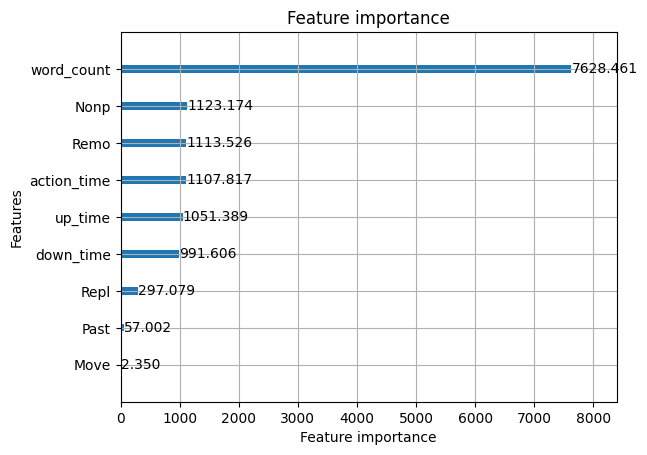

In [ ]:
def feature_eng(df):
  df_train = df[['id', 'down_time']].groupby('id').min()
  df_temp = df[['id', 'up_time']].groupby('id').max()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')
  df_temp = df[['id', 'action_time']].groupby('id').sum()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')
  df_temp = df[['id', 'word_count']].groupby('id').max()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df['activity'] = df['activity'].str[:4]
  df['Inpu'] = df['activity'].apply(lambda x:1 if x=='Input' else 0)
  df['Move'] = df['activity'].apply(lambda x:1 if x=='Move' else 0)
  df['Nonp'] = df['activity'].apply(lambda x:1 if x=='Nonp' else 0)
  df['Past'] = df['activity'].apply(lambda x:1 if x=='Past' else 0)
  df['Remo'] = df['activity'].apply(lambda x:1 if x=='Remo' else 0)
  df['Repl'] = df['activity'].apply(lambda x:1 if x=='Repl' else 0)

  df_temp = df[['id','Inpu','Move','Nonp','Past','Remo','Repl']].groupby('id').sum()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')


  return df_train

model_lgbm = lgbm.LGBMRegressor(n_estimators = 500)
x = feature_eng(train)
y = df_scores['score'].values
model_lgbm.fit(x, y)
lgbm.plot_importance(model_lgbm, importance_type='gain')

特徴量ごとにImportanceを出すと、単語数が圧倒的に重要のようだ。しかし、これは「動作」というよりエッセイの内容そのものに関係しているものだ。次に重要とされた「Input」も、どれだけ入力を行ったかということなので、結局は「どれだけ長いエッセイを作ったか」ということのみが影響を及ぼしているようだ。

動作としてはdown_time, up_timeもそれなりに重要そうである。スコアとの相関関係を確認する。  
corr()で相関をみると、up_timeはプラスの値なので大きくなるほどスコアが良くなる。一方で、down_timeはマイナス値なので小さくなるほどスコアが良くなる。  
つまり、事前に書くことが整理できている人はすぐに書き始め、終わりも時間いっぱい使って多くの文章を書くということが重要そうだ。

<Axes: >

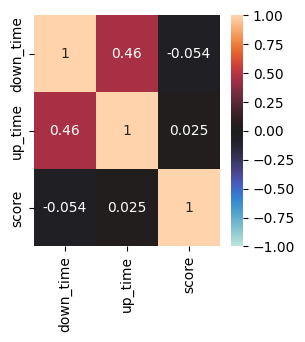

In [ ]:
temp = train[['id', 'down_time']].groupby('id', as_index=False).min()
temp_train = train[['id', 'up_time']].groupby('id', as_index=False).max()
temp = pd.merge(temp, temp_train, on='id', how='left')
temp = pd.merge(temp, df_scores, on='id', how='left')
temp = temp.drop(columns='id')
train_cor = temp.corr()
plt.figure(figsize=(3,3))
sns.heatmap(train_cor, vmax=1, vmin=-1, center=0, annot=True)

## (2) Add Typing info

次に、入力内容そのものも使ってみたい。少し例外はあるが、概ねdown_eventとup_eventは一致しているので、up_eventの中身を見てみる。つまり「何を押したか」である。

In [ ]:
print(train['up_event'].unique())

['Leftclick' 'Shift' 'q' 'Space' 'Backspace' '.' ',' 'Enter' 'ArrowLeft'
 "'" ';' 'ArrowRight' '-' '?' 'Tab' '"' 'ArrowUp' 'ArrowDown' 'm'
 'Rightclick' 'i' 'o' 't' '=' 'a' 'CapsLock' 'Control' 'c' 'v' '/'
 'Delete' ':' 'z' '[' '$' '(' ')' '+' 'Home' 'End' '\\' 'Meta' '*' '&'
 'AudioVolumeMute' 'x' '!' 'Insert' 'MediaPlayPause' 'w' 'NumLock' '%' 'V'
 'b' '>' 'Alt' 'AudioVolumeUp' 'ContextMenu' 'AudioVolumeDown' 'n' 'e' '<'
 'PageDown' ']' 'Middleclick' '@' 'F12' 'u' 'j' 's' '\x96' 'Dead' 'y' '{'
 'ScrollLock' '¿' 'p' 'Process' '}' 'MediaTrackPrevious' 'MediaTrackNext'
 'F3' '^' 'Unidentified' 'Cancel' 'h' '2' 'd' 'r' '`' '\x9b' 'f' 'g' '#'
 '~' 'PageUp' 'l' 'T' 'A' 'S' 'ModeChange' '_' 'Escape' 'F11'
 'Unknownclick' 'AltGraph' 'F10' 'F15' 'Clear' 'OS' 'C' 'Ä±' 'M' '|'
 'â\x80\x93' '0' '1' '5' '\x97' 'Ë\x86' '¡' '\x80' 'Â´' 'Å\x9f' 'F2' 'ä'
 'F1' 'k' 'Pause' 'F6']


色々なコマンドが出てきたが。なんとなくスコアに影響しそうなSpace, Backspace, Delete, Control, Enterに絞って使ってみる。  
なお、このコンペでは出来上がったエッセイの文章そのもので予測がされないように、入力された文字列は「q」に匿名化されている。これらの総数を特徴量に加えたところ、Public Scoreは少し改善した。

## (3) Add Cursor_position info

次に、これまで使ってなかったcursor_positionを使ってみる。cursor_positionは「画面上のカーソルの位置」を示す。平均値も文章作成の進捗等に関係したりと重要な意味を持つものと考えられる。ついでに、単語数の平均値もここで追加すると、スコアは改善した。

In [ ]:
# df_temp = df[['id', 'cursor_position']].groupby('id').max()
# df_temp = df[['id', 'cursor_position']].groupby('id').mean()
# df_temp = df[['id', 'word_count']].groupby('id').mean()

## (4) Add average world length

ここまで見てきたところ、どうやら動作そのものというよりエッセイの中身に関係する特徴量を使うと効果がありそう。試しに、単語の平均的な長さというものと足してみるとスコアが改善した。

In [ ]:
#train['avg_word_len'] = (train['cursor_position_x']-train['Space']) / train['word_count_x']

## (5) Add "how difficult the essay seems"

ここまで見てきたように、文章そのものに関係する特徴量が有効そうだ。  
公開されているデータセットを使用する。  
https://www.kaggle.com/code/jasonheesanglee/updated-22-54-acc-revealing-hidden-words

In [ ]:
essay = pd.read_csv('./data/Essay Constructor Result.csv')
essay.head(10)

,id,essay
0,001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
1,0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
2,0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
3,0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
4,0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."
5,0081af50,qq qqqqq qqqq qqqqqq qqq qqqq qqqqqq qq qqqq q...
6,0093f095,q qqqqqqqq qqqqqqq qqqqqq qqq qqqq qqqqqq qq q...
7,009e23ab,qqqqqqqq qqqqq qqqq qqqqqq qqqqq. qqqqqq qqq q...
8,00e048f1,qq qqqqqq qqqqq qqqq qq qqq qqqqq. qqq qq qqq ...
9,00e1f05a,qqqqqqqqq qq qqq qq qqq qqqq qqqqqqqqq qqqqq q...


「長い単語を使うと加点」されるdifficultyという特徴量を作る。

In [ ]:
pd.set_option('display.max_colwidth', 20)
temp = pd.merge(essay, df_scores, on='id', how='left')
print('Score 6.0:    ', temp.loc[temp['id']=='0042269b', 'essay'])
print('Score 0.5:    ', temp.loc[temp['id']=='c3663a2d', 'essay'])
pd.set_option('display.max_colwidth', 50)

Score 6.0:     2    qqqqqqqqqqq qq q...
Name: essay, dtype: object
Score 0.5:     1848    qq qqqq qqq q qq...
Name: essay, dtype: object


In [ ]:
train.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,cursor_position,word_count,Inpu,Move,Nonp,Past,Remo,Repl,before_change,after_change
0,001519c8,1,4526,4557,31,Nonp,Leftclick,Leftclick,0,0,0,0,1,0,0,0,-,NoChange
1,001519c8,2,4558,4962,404,Nonp,Leftclick,Leftclick,0,0,0,0,1,0,0,0,-,NoChange
2,001519c8,3,106571,106571,0,Nonp,Shift,Shift,0,0,0,0,1,0,0,0,-,NoChange
3,001519c8,4,106686,106777,91,Inpu,q,q,1,1,0,0,0,0,0,0,-,q
4,001519c8,5,107196,107323,127,Inpu,q,q,2,1,0,0,0,0,0,0,-,q


In [ ]:
def text_change(df):
    bf = []
    af = []
    for change in df['text_change']:
        if '=>' in change:
            bf.append(change.split('=>')[0])
            af.append(change.split('=>')[1])
        else:
            bf.append('-')
            af.append(change)
    return pd.Series(bf), pd.Series(af)

train['before_change'], train['after_change'] = text_change(train)
train = train.drop(columns='text_change')
df_test['before_change'], df_test['after_change'] = text_change(df_test)
df_test = df_test.drop(columns='text_change')

def decoder(df, column):
    decoded = []
    for i in tqdm(df[column]):
        try:
            if len(unidecode(i))==0:
                decoded.append('')
            elif len(i) != len(unidecode(i)):
                decoded.append(i[0])
            else:
                decoded.append(unidecode(i))
        except AttributeError:
            decoded.append(i)
    df[f'decoded_{column}'] = pd.Series(decoded)
    return df

import unicodedata
from unidecode import unidecode

dec_col = ['down_event', 'up_event', 'before_change','after_change']
for i in dec_col:
    decoder(train, i)
    decoder(df_test, i)

tr_down_event = [i for i in train['decoded_down_event'].unique().tolist() if 'q' not in i] + ['q']
tr_up_event = [i for i in train['decoded_up_event'].unique().tolist() if 'q' not in i] + ['q']

te_down_event = [i for i in df_test['decoded_down_event'].unique().tolist() if 'q' not in i] + ['q']
te_up_event = [i for i in df_test['decoded_up_event'].unique().tolist() if 'q' not in i] + ['q']

all_event = list(set(tr_down_event + te_down_event + tr_up_event + te_up_event))

useless = ['AudioVolumeMute', 'AudioVolumeDown', 'MediaPlayPause', 'AudioVolumeUp', 'ModeChange', 'ContextMenu', 'Process', 'Middleclick', 'ScrollLock','MediaTrackNext', 'MediaTrackPrevious', 'AltGraph', 'NumLock']
list_of_special_actions = [i for i in all_event if (len(i) > 1) & (i !="A'") & (i not in useless)]
list_of_inputs = [i for i in all_event if (len(i)==1) or (i=="A'")]

KeyError: ignored

In [ ]:
def revealing_text(df):
    string = '' # empty string to add or edit the input sequence
    cursor = 0 # position of cursor
    shift_timer = 0 # Recording `up_time` for `Shift` key if `down_time` != `up_time`
    decoded_num = 0 # Counting the number of decoded char
    INSERT = False # Switch for `Insert` key.
    CAPSLOCK = False # Switch for `CapsLock` key.
    SHIFT = False # Switch for `Shift` key

    '''
    This function converts the list of input sequence to a full essay.
    - OCT 21 2023 Still in progress

    Thank you @kawaiicoderuwu for thoughts on Shift, however... it didn't work...
    I have still implemented the idea.
    Shift reconstructed based on:
    https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/discussion/447735#2487004

    '''
    # Checking whether the reconstruction was done well with comparing the `text_change` column.
    YES = 0
    NO = 0
    sp_character_dict = {';':':',
                         "'": '"',
                        ',':'<',
                        '.':'>',
                        '/':'?',
                        '\\': '|',
                         '1':'!',
                         '2':'@',
                         '3':'#',
                         '4':'$',
                         '5':'%',
                         '6':'^',
                         '7':'&',
                         '8':'*',
                         '9':'(',
                         '0':')',
                         '-':'_',
                         '=':'+',
                         '`':'~',
                         '[':'{',
                         ']':'}'
                        }


    def sentence_splitter(string, char_per_line=140):
        '''
        This function will separate the sentence based on the size of prompt.

        Input :
        string : Sentence
        char_per_line : Number of characters in one line (not sentence).
        Output :
        List of splitted sentences.

        I have manually counted the number of characters per line.
        Based on the prompt depicted in Competition Overview - Data Collection Procedure.
        www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/overview/data-collection-procedure
        '''
        each = []
        remaining_words = len(string) % char_per_line
        full_line = len(string) // char_per_line
        crsr = 0
        for i in range(full_line):
            if crsr == 0:
                each.append(string[:char_per_line])
                crsr = char_per_line
            else:
                each.append(string[crsr:(i+1)*char_per_line])
                crsr = crsr + char_per_line
        each.append(string[:-len(string)%char_per_line +1])
        return each

    def enter_splitter(list_line):
        '''
        This function will split the sentence if it contains \n (Enter) into 2 separate string.

        Input :
        list_line : Sentences in list (connected with `sentence_splitter` function in this notebook.)
        Output :
        enter_splitted : List of splitted sentence.
        '''
        enter_splitted = []
        for line in list_line:
            if '\n' in line:
                for lin in line.split('\n'):
                    if lin != line.split('\n')[-1]:
                        enter_splitted.append(lin+'\n')
                    else:
                        enter_splitted.append(lin)
            else:
                enter_splitted.append(line)
        return enter_splitted

    for row_num in range(df.shape[0]): # iterates over each row in df.
        # I was lazy to type `df['down_event'].iloc[row_num]` all the time.
        action = df['decoded_down_event'].iloc[row_num]
        if action in useless:
            continue
        if action == ' ':
            decoded_num = decoded_num + 1
        # I used `df['cursor_position'].iloc[row_num]` everywhere in the code
        # and I think not putting this in a variable was the problem.
        cursor_now = df['cursor_position'].iloc[row_num]

        # Config... kinda?

        if action == 'Insert':
            if INSERT == True:
                INSERT = False
                continue
            else:
                INSERT = True
                continue

        elif action == 'CapsLock':
            if CAPSLOCK == True:
                CAPSLOCK = False
                continue
            else:
                CAPSLOCK = True
                continue

        if action == 'Shift' and (df['down_time'].iloc[row_num] != df['up_time'].iloc[row_num]):
            shift_timer = df['up_time'].iloc[row_num]
            SHIFT = True
            continue

        if shift_timer != 0:
            shift_timer = 0
            SHIFT = False

        '''
        I have added two if-statements above to be prepared for the occasion
        where `down_time` and `up_time` is different for `Shift`.
        As all `down_time` and `up_time` are the same in training data,
        these conditions wouldn't be activated.
        '''


        if shift_timer == 0:
            if action == 'Shift':
                SHIFT = True
                continue

            elif df['decoded_down_event'].iloc[row_num-2] == 'Shift':
                SHIFT = False

        if row_num == 0:
            cursor = 0

        else:
            cursor = df['cursor_position'].iloc[row_num-1]


        ################################################################
        ################################################################

        # Cursor position


        if (action == 'Tab')&(row_num!=0):
            if df['decoded_down_event'].iloc[row_num-1] == 'Alt':
                '''
                Ignores `Alt + Tab`, which is the window switching keyboard shortcut.
                Not sure if it is in the sequence, but I just added it.
                '''
                continue


            if cursor == len(string):
                '''
                Adding `\t` for `Tab` at the end of the string.
                '''
                string = string + '\t'
                cursor = cursor_now
                continue


            else:
                '''
                Adding `\t` for `Tab` where the cursor is positioned at.
                '''
                string = string[:cursor] + '\t' + string[cursor:]
                cursor = cursor_now
                continue


        ################################################################
        ################################################################

        # Remove/Cut
        if df['activity'].iloc[row_num] == 'Remove/Cut':
            '''
            For Backspace & Delete, we can only consider when the activity == 'Remove/Cut'.
            '''
            if action == 'Backspace':

                # When the cursor is at the end of the string.
                if cursor == len(string):
                    # Simply removes the last character.
                    string = string[:-1]
                    # The cursor repositions as the length of the string decreases.
                    cursor = cursor_now
                    continue

                elif cursor == 0:
                    '''
                    There is no point of `Backspace` when the cursor is at the beginning of the whole essay.
                    '''
                    cursor = cursor_now
                    continue
                else:
                    '''
                    When the cursor is in the middle of the string.
                    Removes the last character before the cursor position and add the remaining string.
                    '''
                    string = string[:cursor-1] + string[cursor:]
                    # The cursor repositions as the length of the string decreases.
                    cursor = cursor_now
                    continue

            elif action == 'Delete':
                '''
                There is no point of `Delete` when the cursor is at the end of the sentence.
                '''
                if cursor == len(string):
                    cursor = cursor_now
                    continue

                # When the cursor is positioned at the beginning of the essay.
                elif cursor == 0:
                    '''
                    Simply deletes the first character of the whole essay.
                    '''
                    string = string[1:]
                    cursor = cursor_now
                    continue

                else:
                    '''
                    When the cursor is in the middle of the sentence.
                    A character right after the cursor position is removed,
                    then it is added to the string before the cursor.
                    '''
                    string = string[:cursor] + string[cursor+1:]
                    '''
                    Cursor doesn't move, check the discussion below.
                    https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/discussion/448180#2488038
                    '''
                    cursor = cursor_now
                    continue

        ################################################################
        ################################################################

        elif df['activity'].iloc[row_num].startswith('Move'):
            act = df['activity'].iloc[row_num].split()
            before_start = int(act[2][1:-1])
            before_end = int(act[3][0:-1])
            after_start = int(act[5][1:-1])
            after_end = int(act[6][0:-1])

            string_to_be_moved = string[before_start:before_end]
            string = string[:before_start] + string[before_end:after_start] + string_to_be_moved + string[after_end:]
            cursor = cursor_now
            continue

        ################################################################
        ################################################################

        elif df['activity'].iloc[row_num] == 'Paste':
            string = string[:cursor] + df['decoded_after_change'].iloc[row_num] + string[cursor:]
            cursor = cursor_now
            continue

        ################################################################
        ################################################################

        elif df['activity'].iloc[row_num] == 'Input':
            input_ = df['decoded_after_change'].iloc[row_num]
            if input_ in list_of_inputs:
                # When the `Insert` switch is off.
                if INSERT == False:
                    # When the `CapsLock` switch is off.
                    if CAPSLOCK == False:
                        # When the cursor is at the end of the string.
                        if cursor == len(string):
                            # When Shift switch is off
                            if SHIFT == False:
                                '''
                                The input is simply added at the end of the string.
                                '''
                                string = string + input_
                                cursor = cursor_now
                                continue

                            else: # When Shift switch is on.
                                if input_.isalpha():
                                    '''
                                    The capitalized input is added at the end of the string.
                                    '''
                                    string = string + input_.upper()
                                    cursor = cursor_now
                                    continue

                                elif input_ in sp_character_dict.keys():
                                    '''
                                    The keys are removed, replaced with the values. (Based on my keyboard)
                                    But I think the values are already in the sequence.
                                    '''
                                    string = string + sp_character_dict.get(input_)
                                    cursor = cursor_now
                                    continue

                                else:
                                    string = string + input_
                                    cursor = cursor_now
                                    continue

                        else:
                            '''
                            When the cursor is not at the end of the string.
                            '''
                            if SHIFT == False:
                                '''
                                The input is added at the cursor position.
                                '''
                                string = string[:cursor] + input_ + string[cursor:]
                                cursor = cursor_now
                                continue
                            else:
                                if input_.isalpha():
                                    string = string[:cursor] + input_.upper() + string[cursor:]
                                    cursor = cursor_now
                                    continue

                                elif input_ in sp_character_dict.keys():
                                    string = string[:cursor] + sp_character_dict.get(input_)  + string[cursor:]
                                    cursor = cursor_now
                                    continue

                                else:
                                    string = string[:cursor] + input_ + string[cursor:]
                                    cursor = cursor_now
                                    continue
                    else:
                        '''
                        When `CapsLock` switch is on.
                        When the cursor is at the end of the essay.
                        '''
                        if cursor == len(string):
                            if input_.isalpha():
                                '''
                                The alphabets typed after this loop will be in capitals until the CapsLock is turned off.
                                '''
                                string = string + input_.upper()
                                cursor = cursor_now
                                continue

                            else:
                                '''
                                As the `CapsLock` is only applied to the alphabets,
                                no special action is need for non-alphabets.
                                '''
                                string = string + input_
                                cursor = cursor_now
                                continue

                        else:
                            '''
                            When the cursor is positioned in the middle of the string.
                            A caplitalized alphabet is added at the cursor position.
                            '''
                            string = string[:cursor] + input_.upper() + string[cursor:]
                            cursor = cursor_now
                            continue


                else: # When `Insert` switch is on.
                    '''
                    I will skip the explanations for `CapsLock` and focus more on `Insert`
                    '''
                    if CAPSLOCK == False:
                        if cursor == len(string):
                            if SHIFT == False:
                                string = string + input_
                                cursor = cursor_now
                                continue

                            else:
                                if input_.isalpha():
                                    string = string + input_.upper()
                                    cursor = cursor_now
                                    continue

                                elif input_ in sp_character_dict.keys():
                                    string = string + sp_character_dict.get(input_)
                                    cursor = cursor_now
                                    continue

                                else:
                                    string = string + input_
                                    cursor = cursor_now
                                    continue

                        else: # When the cursor is in the middle of the string.
                            if SHIFT == False:
                                string = string[:cursor] + input_ + string[cursor+1:]
                                cursor = cursor_now
                                continue

                            else:
                                if input_.isalpha()==True:
                                    string = string[:cursor] + input_.upper() + string[cursor+1:]
                                    cursor = cursor_now
                                    continue

                                elif input_ in sp_character_dict.keys():
                                    string = string[:cursor] + sp_character_dict.get(input_) + string[cursor+1:]
                                    cursor = cursor_now
                                    continue

                                else:
                                    string = string[:cursor]+ input_ + string[cursor+1:]
                                    cursor = cursor_now
                                    continue

                            '''
                            It takes full string before the cursor position
                            Add input
                            Then add removes the first character of the remaining string and add it to the previous string.
                            This logic applies to the whole `else` statement, so I will skip.
                            '''

                    else: # When CapsLock is on.
                        if cursor == len(string):
                            if input_.isalpha():
                                string = string + input_.upper()
                                cursor = cursor_now
                                continue

                            else: # When the action is not alphabet.
                                if SHIFT==False:
                                    string = string + input_
                                    cursor = cursor_now
                                    continue

                                elif input_ in sp_character_dict.keys():
                                    string = string + sp_character_dict.get(input_)
                                    cursor = cursor_now
                                    continue
                                else:
                                    string = string + action
                                    cursor = cursor_now
                                    continue
                        else:
                            if input_.isalpha()==True:
                                string = string[:cursor] + input_.upper() + string[cursor+1:]
                                cursor = cursor_now
                                continue

                            else:
                                if SHIFT==False:
                                    string = string[:cursor] + input_ + string[cursor+1:]
                                    continue

                                elif input_ in sp_character_dict.keys():
                                    string = string[:cursor] + sp_character_dict.get(input_) + string[cursor+1:]
                                    cursor = cursor_now
                                    continue

                                else:
                                    string = string[:cursor] + input_ + string[cursor+1:]
                                    cursor = cursor_now
                                    continue

            ################################################################

            if action == 'Space': # When the `Space` was inserted
                if cursor == len(string):
                    string = string + input_
                    cursor = cursor_now
                    continue

                else:
                    if INSERT == False:
                        '''
                        When `Insert` switch is off and the cursor is not positioned at the end of the sentence.
                        '''
                        string = string[:cursor] + input_ + string[cursor:]
                        cursor = cursor_now
                        continue

                    else:
                        '''
                        When `Insert` switch is on and the cursor is not positioned at the end of the sentence.
                        '''
                        string = string[:cursor] + input_ + string[cursor+1:]
                        cursor = cursor_now
                        continue

            ################################################################

            elif action == 'Enter': # When the `Enter` was inserted
                if cursor == len(string):
                    string = string + input_
                    cursor = cursor_now
                    continue

                else:
                    string = string[:cursor] + input_ + string[cursor:]
                    cursor = cursor_now
                    continue

        ################################################################
        ################################################################


        elif (df['activity'].iloc[row_num] == 'Replace') & (df['decoded_before_change'].iloc[row_num]!='-'):
            '''
            When the `activity` column is set as `Replace`.
            '''
            before = df['decoded_before_change'].iloc[row_num].strip() # string to be replaced.
            after = df['decoded_after_change'].iloc[row_num].strip() # string replaced.

            string = string[:cursor-len(before)-1] + after + string[cursor:]
            cursor = cursor_now
            continue

    if len(string.split()) - decoded_num == df['word_count'].iloc[row_num]:
        '''
        Check if the replace was well-performed.
        Which most probably means my reconstruction worked well.
        '''
        YES = YES+1
    else:
        '''
        My reconstruction didn't work well.... omg... Need to work harder.
        '''
        NO = NO+1
    return string, YES, NO
def essay_difficulty(df):
    df['token'] = [word_tokenize(p) for p in df["essay"]]
    df['token_len'] = df['token'].apply(lambda x : list(len(word) for word in x))
    df['verylong']  = df['token_len'].apply(lambda x : sum(c>=9 for c in x))
    df['long']      = df['token_len'].apply(lambda x : sum(c==7 or c==8 for c in x))
    df['mid']       = df['token_len'].apply(lambda x : sum(c==5 or c==6 for c in x))
    df['difficulty'] = df['verylong']*5 + df['long']*3 + df['mid']*1

    df['long_words'] = df['verylong']+df['long']

    return df

最後に検討した特徴量をまとめて、学習を実施する。

In [ ]:
def essay_difficulty(df):
  df['token'] = [word_tokenize(p) for p in df['essay']]
  df['token_len'] = df['token'].apply(lambda x: list(len(word) for word in x))
  df['verylong'] = df['token_len'].apply(lambda x: sum(c>9 for c in x))
  df['long'] = df['token_len'].apply(lambda x: sum(c==7 or x==8 for c in x))
  df['mid'] = df['token_len'].apply(lambda x: sum(c==5 or x==6 for c in x))
  df['difficulty'] = df['verylong']*5 + df['long']*3 + df['mid']*1

  df['long_words'] = df['verylong'] + df['long']

  return df

In [ ]:
def feature_eng(df):
  df_train = df[['id','down_time']].groupby('id').min()
  df_temp = df[['id', 'up_time']].groupby('id').max()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df_temp = df[['id', 'action_time']].groupby('id').mean()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')
  df_temp = df[['id', 'action_time']].groupby('id').sum()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df_temp = df[['id', 'word_count']].groupby('id').max()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')
  df_temp = df[['id', 'word_count']].groupby('id').mean()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df_temp = df[['id', 'cursor_position']].groupby('id').max()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')
  df_temp = df[['id', 'cursor_position']].groupby('id').mean()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df['activity'] = df['activity'].str[:4]
  df['Inpu'] = df['activity'].apply(lambda x:1 if x=='Inpu' else 0)
  df['Move'] = df['activity'].apply(lambda x:1 if x=='Move' else 0)
  df['Nonp'] = df['activity'].apply(lambda x:1 if x=='Nonp' else 0)
  df['Past'] = df['activity'].apply(lambda x:1 if x=='Past' else 0)
  df['Remo'] = df['activity'].apply(lambda x:1 if x=='Remo' else 0)
  df['Repl'] = df['activity'].apply(lambda x:1 if x=='Repl' else 0)
  df_temp = df[['id', 'Inpu', 'Move', 'Nonp', 'Past', 'Remo', 'Repl']].groupby('id').sum()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df['Space'] = df['up_event'].apply(lambda x:1 if x='Space' else 0)
  df['Backspace'] = df['up_event'].apply(lambda x:1 if x='Backspace' else 0)
  df['Delete'] = df['up_event'].apply(lambda x:1 if x='Delete' else 0)
  df['Control'] = df['up_event'].apply(lambda x:1 if x='Control' else 0)
  df['Enter'] = df['up_event'].apply(lambda x:1 if x='Enter' else 0)
  df_temp = df[['id', 'Space', 'Backspace', 'Delete', 'Control', 'Enter']].groupby('id').sum()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  df_train['avg_word_len'] = (df_train['cursor_position'] - df_train['Space']) / df_train['word_count']

  df['diff'] = df['down_time'] - df['up_time'].shift(1)
  df['diff'] = df['diff'].apply(lambda x : 0 if x<0 else x)
  df_temp = df[['id', 'diff']].groupby('id').mean()
  df_train = pd.merge(df_train, df_temp, on='id', how='left')

  return df_train

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4675
[LightGBM] [Info] Number of data points in the train set: 2471, number of used features: 24
[LightGBM] [Info] Start training from score 3.711251


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

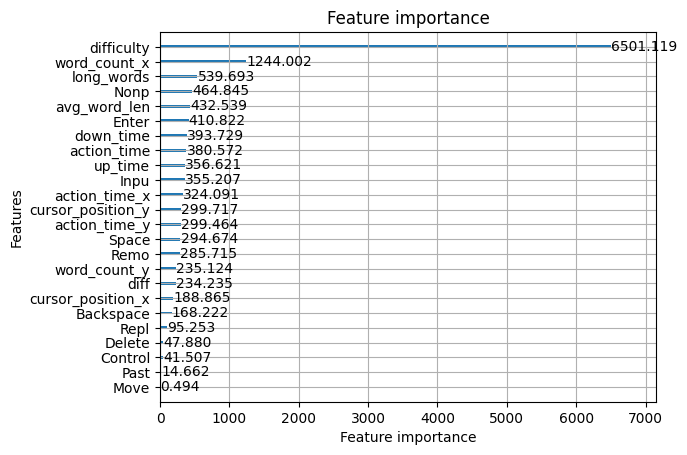

In [ ]:
model_lgbm = lgbm.LGBMRegressor(n_estimators = 500, metric="rmse")

essay = essay_difficulty(essay)
x = feature_eng(train)
x = pd.merge(x, essay[["id","difficulty", "long_words"]], on ="id", how="left")
x = x.drop(columns="id")
y= df_scores["score"].values

model_lgbm.fit(x, y)
lgbm.plot_importance(model_lgbm, importance_type="gain")

In [ ]:
x.head(10)

,down_time,up_time,action_time_x,action_time_y,action_time,word_count_x,word_count_y,cursor_position_x,cursor_position_y,Inpu,Move,Nonp,Past,Remo,Repl,Space,Backspace,Delete,Control,Enter,avg_word_len,diff,difficulty,long_words
0,4526,1801969,116.246774,297243,2259,256,128.116152,1539,711.163473,2010,3,120,0,417,7,357,417,0,0,4,4.617188,599.057903,312,64
1,30623,1788969,112.221271,275391,1758,323,182.714751,1676,776.205786,1938,0,254,1,260,1,391,260,0,0,6,3.978328,612.204564,179,30
2,4441,1771669,101.837766,421201,3005,404,194.772727,2291,731.611702,3515,0,175,0,439,7,552,439,0,0,17,4.304455,342.973646,597,131
3,41395,1404469,121.848329,189596,806,206,103.618895,1047,542.537275,1304,0,99,1,151,1,243,152,0,4,3,3.902913,760.312339,190,40
4,78470,1662472,123.943896,313702,701,252,125.082971,1402,600.050968,1942,0,72,0,517,0,324,517,0,0,10,4.277778,512.708811,216,44
5,42636,1778916,81.404342,179985,1102,275,132.942560,1445,662.532338,1794,0,76,0,338,3,327,340,0,0,3,4.065455,706.032112,186,28
6,6572,1768197,109.717847,193652,501,242,119.671388,1438,685.228329,1583,0,34,0,148,0,257,148,0,0,4,4.880165,895.753541,268,55
7,106549,1799303,90.755631,213548,803,308,154.297068,1768,790.445389,1975,0,155,0,222,1,366,219,3,0,9,4.551948,634.323417,274,56
8,5273,1797498,75.011356,118893,613,223,114.762776,1308,664.476341,1426,0,41,0,118,0,245,120,0,0,5,4.766816,1055.757098,212,36
9,10731,1853697,93.343215,730504,11017,739,364.352159,4110,1789.351265,6145,0,228,0,1446,7,1087,1432,0,2,8,4.090663,151.680680,725,157
